<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

# Demo: The Generative Toolkit for Scientific Discovery


In [1]:
# logging
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import logging, sys
logging.disable(sys.maxsize)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from paccmann_chemistry.utils import disable_rdkit_logging
# utils
import numpy as np
import pandas as pd
from tqdm import tqdm
from paccmann_generator.drug_evaluators.esol import ESOL
from paccmann_generator.drug_evaluators.scsore import SCScore
from terminator.selfies import encoder, split_selfies
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
# plotting
import mols2grid
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# gt4sd
from gt4sd.algorithms.generation.moler import MoLeR, MoLeRDefaultGenerator
from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules
)

Using TensorFlow backend.


### Let us have a look at a case study

In [2]:
molecule_name, smiles = (
    "Buturon",
    "CC(C#C)N(C)C(=O)NC1=CC=C(Cl)C=C1"
)  # https://pubchem.ncbi.nlm.nih.gov/compound/19587
# molecule_name, smiles = (
#     "SPD304",
#     "CC1=CC2=C(C=C1C)OC=C(C2=O)CN(C)CCN(C)CC3=CN(C4=CC=CC=C43)C5=CC=CC(=C5)C(F)(F)F"
# ) # https://pubchem.ncbi.nlm.nih.gov/compound/5327044
# molecule_name, smiles = (
#     "OrganicSemiConductor",
#     "Cc1nc(-c2nc(C)c(-c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)C)s3)s2)sc1-c1cccs1"
# ) # organic semi-conductor from DeepSearch query
molecule = Chem.MolFromSmiles(smiles)
fingerprint = GetMorganFingerprintAsBitVect(molecule, radius=2)
solubility_fn = lambda smi: ESOL().calc_esol(Chem.MolFromSmiles(smi))
complexity_fn = lambda smi: SCScore()(Chem.MolFromSmiles(smi))
molecular_weight_fn = lambda smi: MolWt(Chem.MolFromSmiles(smi))

similarity_fn = lambda smi: FingerprintSimilarity(
    fingerprint,
    GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2)
)
solubility = solubility_fn(smiles)

mols2grid.display(
    pd.DataFrame({
        "SMILES": [smiles], "Name": [molecule_name], "Solubility": [solubility],
        "Solubility Val": [f"Solubility = {x:.3f}" for x in [solubility]]
    }),
    size=(800,250), tooltip=["SMILES", "Name", "Solubility"], subset=["Name", "img", "Solubility Val"]
)

# GT4SD Discovery usecase

## Find similar molecules controlling the solubility

### **Goal:** 

Here we are trying to modify the molecule considered to generate different alternatives controlling the solubility using ESOL from Dealney.

References:

```txt
Dealney J. S. (2004). ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure. J. Chem. Inf. Comput. Sci. 2004, 44, 3, 1000–1005.
```

## Finding alternatives using the RegressionTransformer

We start considering a methodology based on language modeling relying on the RegressionTransformer

References:

```txt
Born, J., & Manica, M. (2022). Regression Transformer: Concurrent Conditional Generation and Regression by Blending Numerical and Textual Tokens. ICLR Workshop on Machine Learning for Drug Discovery.
```

In [3]:
# some utilities
def mask_selfies(s: str, p: float) -> str:
    property_part, molecule_part = s.split("|")
    tokens = [t if np.random.sample() > p else "[MASK]" for t in split_selfies(molecule_part)]
    return property_part + "|" + "".join(tokens)


def plot_molecules_df(molecules_df: pd.DataFrame, similarity_threshold: float) -> None:
    molecules_df_to_plot = molecules_df.sort_values(by="similarity", ascending=False)
    molecules_df_to_plot["text"] = molecules_df_to_plot.apply(lambda x: f"Solubility (log(mol/L))={x['solubility']:.2f}", axis=1)
    return mols2grid.display(
        molecules_df_to_plot[molecules_df_to_plot["similarity"] > similarity_threshold], smiles_col="smiles", n_cols=3,
        size=(300,200), tooltip=["smiles", "solubility", "similarity", "molecular_weight", "scs_score"],
        subset=["smiles", "img", "text"]
    )

In [4]:
attempts = 20
samples = 5
change_probabilities = [0.15, 0.5]
desired_solubility = solubility + 3.
similarity_threshold = .1

selfies = encoder(smiles)
property_with_selfies = f"<esol>{desired_solubility:.2f}|" + selfies

first_set_configuration = RegressionTransformerMolecules(
    algorithm_version="solubility", search="sample", temperature=1.5, tolerance=60
)

first_set_molecules_df = pd.DataFrame()
generated_smiles = set()

for i in tqdm(range(attempts), total=attempts, desc="Processing RT number:"):
    seed_property_with_selfies = mask_selfies(property_with_selfies, np.random.uniform(*change_probabilities))
    algorithm = RegressionTransformer(configuration=first_set_configuration, target=seed_property_with_selfies)
    generated_smiles = set()
    
    while len(generated_smiles) < samples:
        generated_samples = list(algorithm.sample(samples))
        for s in generated_samples:
            if s[0] not in generated_smiles and s[0] != smiles and s[0]:
                generated_smiles = generated_smiles.union([s[0]])
    first_set_molecules_df = pd.concat([
        first_set_molecules_df,
        pd.DataFrame({
            "smiles": list(generated_smiles),
            "solubility": list(map(lambda smi: solubility_fn(smi), generated_smiles)),
            "similarity": list(map(similarity_fn, generated_smiles)),
            "molecular_weight": list(map(molecular_weight_fn, generated_smiles)),
            "scs_score": list(map(complexity_fn, generated_smiles)),
        })
    ], axis=0)
first_set_molecules_df


In [6]:
plot_molecules_df(molecules_df=first_set_molecules_df, similarity_threshold=similarity_threshold)

Text(0.5, 1.0, 'Solubility using Buturon as a reference')

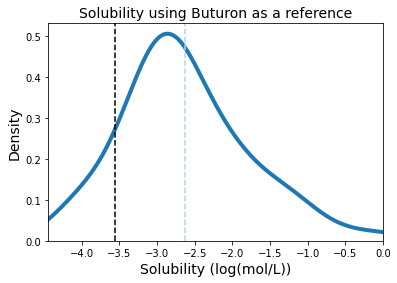

In [7]:
%matplotlib inline
sns.distplot(first_set_molecules_df["solubility"], hist=False, kde_kws={"linewidth": 4})
plt.axvline(x=first_set_molecules_df["solubility"].mean(), linestyle="--", c="lightblue")
plt.axvline(x=solubility, linestyle="--", c="k")
plt.xlabel("Solubility (log(mol/L))", size=14)
plt.ylabel("Density", size=14)
plt.xlim([min(first_set_molecules_df["solubility"].min(), solubility) - .1, 0.0])
plt.title(f"Solubility using {molecule_name} as a reference", size=14)

## Exploring interesting scaffolds

At this point we can explore some of the generated scaffolds to evaluate further alternatives, for this we use another generative algorithm hosted in the GT4SD, MoLeR.

References:

```txt
Maziarz, K., Jackson-Flux, H., Cameron, P., Sirockin, F., Schneider, N., Stiefl, N., Segler, M., & Brockschmidt, M. (2022). Learning to Extend Molecular Scaffolds with Structural Motifs. ICLR.
```

In [8]:
number_of_scaffolds = 6
batch_size = 32
scaffolds_set = set([Chem.MolToSmiles(GetScaffoldForMol(Chem.MolFromSmiles(smi))) for smi in first_set_molecules_df[first_set_molecules_df["similarity"] > similarity_threshold].sort_values(by="similarity", ascending=False)[:number_of_scaffolds]["smiles"]])
second_set_configuration = MoLeRDefaultGenerator(scaffolds=".".join(scaffolds_set))
algorithm = MoLeR(configuration=second_set_configuration)

In [9]:
mols2grid.display([Chem.MolFromSmiles(smi) for smi  in second_set_configuration.scaffolds.split(".")], n_cols=3, size=(300,200))

In [10]:
generated_smiles = set()
maximum_calls = 5
counter = 0
while len(generated_smiles) < (attempts * samples) and counter < maximum_calls:
    generated_smiles = generated_smiles.union([smi for smi in list(algorithm.sample(batch_size)) if smi not in generated_smiles and smi != smiles])
    counter += 1
second_set_molecules_df = pd.DataFrame({
    "smiles": list(generated_smiles),
    "solubility": list(map(lambda smi: solubility_fn(smi), generated_smiles)),
    "similarity": list(map(similarity_fn, generated_smiles)),
    "molecular_weight": list(map(molecular_weight_fn, generated_smiles)),
    "scs_score": list(map(complexity_fn, generated_smiles)),
})
second_set_molecules_df

Loading a trained model from: /Users/tte/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl
Loading a trained model from: /Users/tte/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl
Loading a trained model from: /Users/tte/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl
Loading a trained model from: /Users/tte/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


,smiles,solubility,similarity,molecular_weight,scs_score
0,COOC(C)(C)C(O)CC(C1=CC=C(OCC2=CC=CC=C2)C=C1)C(C)C,-6.149453,0.102941,372.505,3.607044
1,COC1=CC=C(C=CC(=O)NCC(C2=CC=C([N+](=O)[O-])O2)...,-4.569251,0.108434,382.376,2.367165
2,CC1(C)CC(=O)C2=C(C1)NC1=C(C(=O)CCC1)C2C1=CC=C(...,-5.878387,0.144928,373.855,2.384723
3,CC1=CC=CC(C2=CC=C(S(=O)(=O)C3=CC=CC=C3)C=C2C(=...,-6.602023,0.091954,704.827,1.222386
4,CCSC=CC(=O)C=CC1=CC=CC(C(F)(F)F)=C1,-5.127765,0.142857,286.318,3.608933
...,...,...,...,...,...
123,CC1=CC=C(C)C(C2=CC=CC3=NC=CC=C23)=C1,-5.008695,0.066667,233.314,2.748667
124,CC(C)CC1=CSC(C2=NN(CC3=CC=CC=C3)C=C2NC(=O)NC2=...,-10.647524,0.209302,632.617,1.001091
125,CC1=CC=C(C2=CN3C=C(C4=CC=C(OCC5=NN=CO5)C=C4)N=...,-5.853729,0.053333,383.411,2.132539
126,CCC=CC1=CC=C(OCC2=CC=C(F)C(C(=O)O)=C2)C=C1,-5.293811,0.119403,300.329,2.740461


In [11]:
plot_molecules_df(molecules_df=second_set_molecules_df, similarity_threshold=similarity_threshold)

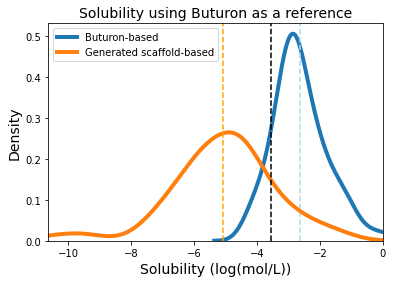

In [12]:
%matplotlib inline
minimum_value = min(first_set_molecules_df["solubility"].min(), second_set_molecules_df["solubility"].min())
sns.distplot(first_set_molecules_df["solubility"], label=f"{molecule_name}-based", hist=False, kde_kws={"linewidth": 4})
plt.axvline(x=first_set_molecules_df["solubility"].mean(), linestyle="--", c="lightblue")
sns.distplot(second_set_molecules_df["solubility"], label="Generated scaffold-based", hist=False, kde_kws={"linewidth": 4})
plt.axvline(x=second_set_molecules_df["solubility"].mean(), linestyle="--", c="orange")
plt.axvline(x=solubility, linestyle="--", c="k")
plt.xlabel("Solubility (log(mol/L))", size=14)
plt.ylabel("Density", size=14)
plt.xlim([min([first_set_molecules_df["solubility"].min(), second_set_molecules_df["solubility"].min(), solubility]), 0.0])
plt.title(f"Solubility using {molecule_name} as a reference", size=14)
plt.legend()

Text(0.5, 1.0, 'Analyzing the landscape of the generated molecules')

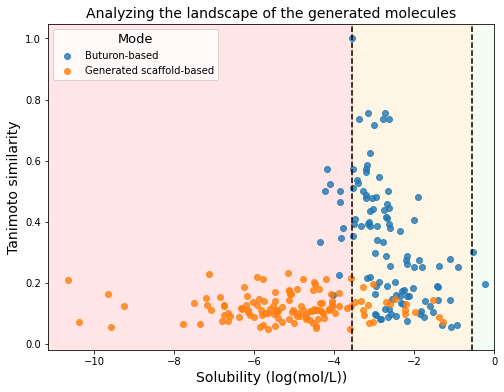

In [13]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8 , 6))

plt.axvline(x=desired_solubility, linestyle="--", c="k")
plt.axvline(x=solubility, linestyle="--", c="k")
ax.axvspan(xmin=desired_solubility, xmax=0.0, alpha=0.1, color="lightgreen")
ax.axvspan(xmin=solubility, xmax=desired_solubility, alpha=0.1, color="orange")
ax.axvspan(xmin=minimum_value - .5, xmax=solubility, alpha=0.1, color="red")
plt.scatter(first_set_molecules_df["solubility"], first_set_molecules_df["similarity"], label=f"{molecule_name}-based", alpha=0.8)
plt.scatter(second_set_molecules_df["solubility"], second_set_molecules_df["similarity"], label="Generated scaffold-based", alpha=0.8)
plt.xlabel("Solubility (log(mol/L))", size=14)
plt.ylabel("Tanimoto similarity", size=14)
plt.legend(title="Mode", title_fontsize=13)
plt.xlim([minimum_value - .5, 0.0])
plt.title("Analyzing the landscape of the generated molecules", size=14)